In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [201]:
import os
this_directory = os.path.realpath(".")
home_directory = os.path.split(this_directory)[0]
data_directory = os.path.join(home_directory, "data")
images_directory = os.path.join(home_directory, "images")

In [228]:
features = pd.read_pickle("{}/qozs_features.pkl".format(data_directory))
features.reset_index(inplace=True, drop=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 16 columns):
population_total           8685 non-null float64
age_median                 8682 non-null float64
p_never_married            8685 non-null float64
p_white                    8685 non-null float64
p_black                    8685 non-null float64
p_poverty                  8685 non-null float64
household_income_median    8657 non-null float64
home_value_median          8382 non-null float64
structure_year_median      8661 non-null float64
p_outofcountyflux          7822 non-null float64
p_pop_renting              8679 non-null float64
p_units_vacant             8679 non-null float64
p_mobilehomes              8679 non-null float64
p_multiple_unit_strucs     8679 non-null float64
state                      8685 non-null object
tract                      8685 non-null object
dtypes: float64(14), object(2)
memory usage: 1.1+ MB


# Can skip this part if you have already generated state_info.pkl

# Start here!

In [229]:
state_info = pd.read_pickle(f"{data_directory}/states.pkl")

Top 10 States : ['PR' 'WY' 'MS' 'AK' 'DC' 'VT' 'AL' 'GA' 'LA' 'KY']


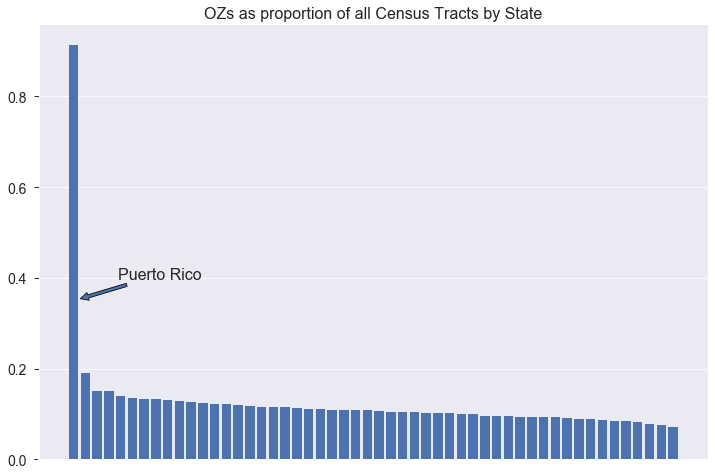

In [230]:
## OZs as proportion of all census tracts in a state
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(12,8))

p_ozs = state_info['n_ozs'].values / state_info['n_tracts'].values
sort_i = np.argsort(p_ozs)[::-1]
x = np.arange(len(p_ozs))

ax.bar(x, p_ozs[sort_i], label = f"Top 10 States : \n {state_info.abbr.values[sort_i][:10]}")
ax.set_title("OZs as proportion of all Census Tracts by State", fontsize=16)
ax.set_xticks([])
ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=14)
ax.annotate('Puerto Rico', (40, 160), xytext = (80, 180),\
            xycoords='axes points', arrowprops={'arrowstyle':'simple'}, fontsize=16)
#fig.legend(loc=(10,10))

plt.savefig(f"{images_directory}/ozs_by_states.png", dpi=120)
print(f"Top 10 States : {state_info.abbr.values[sort_i][:10]}")

In [231]:
# Tracts by state w/o Puerto Rico
# fig, ax = plt.subplots(figsize=(12,8))

# ax.bar(x[1:], p_ozs[sort_i][1:])
# ax.set_title("Without Puerto Rico", fontsize=16)
# ax.set_xticks([])
# ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=14)

# plt.savefig(f"{images_directory}/ozs_by_state_wo_PR.png", dpi=120)

In [232]:
plotter_features = features.drop(columns=['tract', 'state'])
plotter_features.columns[1]

'age_median'

In [233]:
PR = features[features['state'] == '72']
all_others = features[features['state'] != '72']

In [234]:
## make sure the big negative numbers were replaced with nans
features.iloc[6945]

population_total                    15
age_median                         NaN
p_never_married                      1
p_white                              1
p_black                              0
p_poverty                            1
household_income_median            NaN
home_value_median                  NaN
structure_year_median              NaN
p_outofcountyflux                  NaN
p_pop_renting                        1
p_units_vacant                   0.632
p_mobilehomes                        0
p_multiple_unit_strucs               0
state                               72
tract                      72127980000
Name: 6945, dtype: object

In [257]:
us_ = {'household_income_median':63179, 
    'age_median': 38.2,
    'p_poverty': 0.118,
    'p_black': 0.127,
    'p_white' : 0.730,
    'home_value_median':217600,
    'p_vacancy': 0.0315}

In [261]:
demo_dir = os.path.join(images_directory, 'demography')

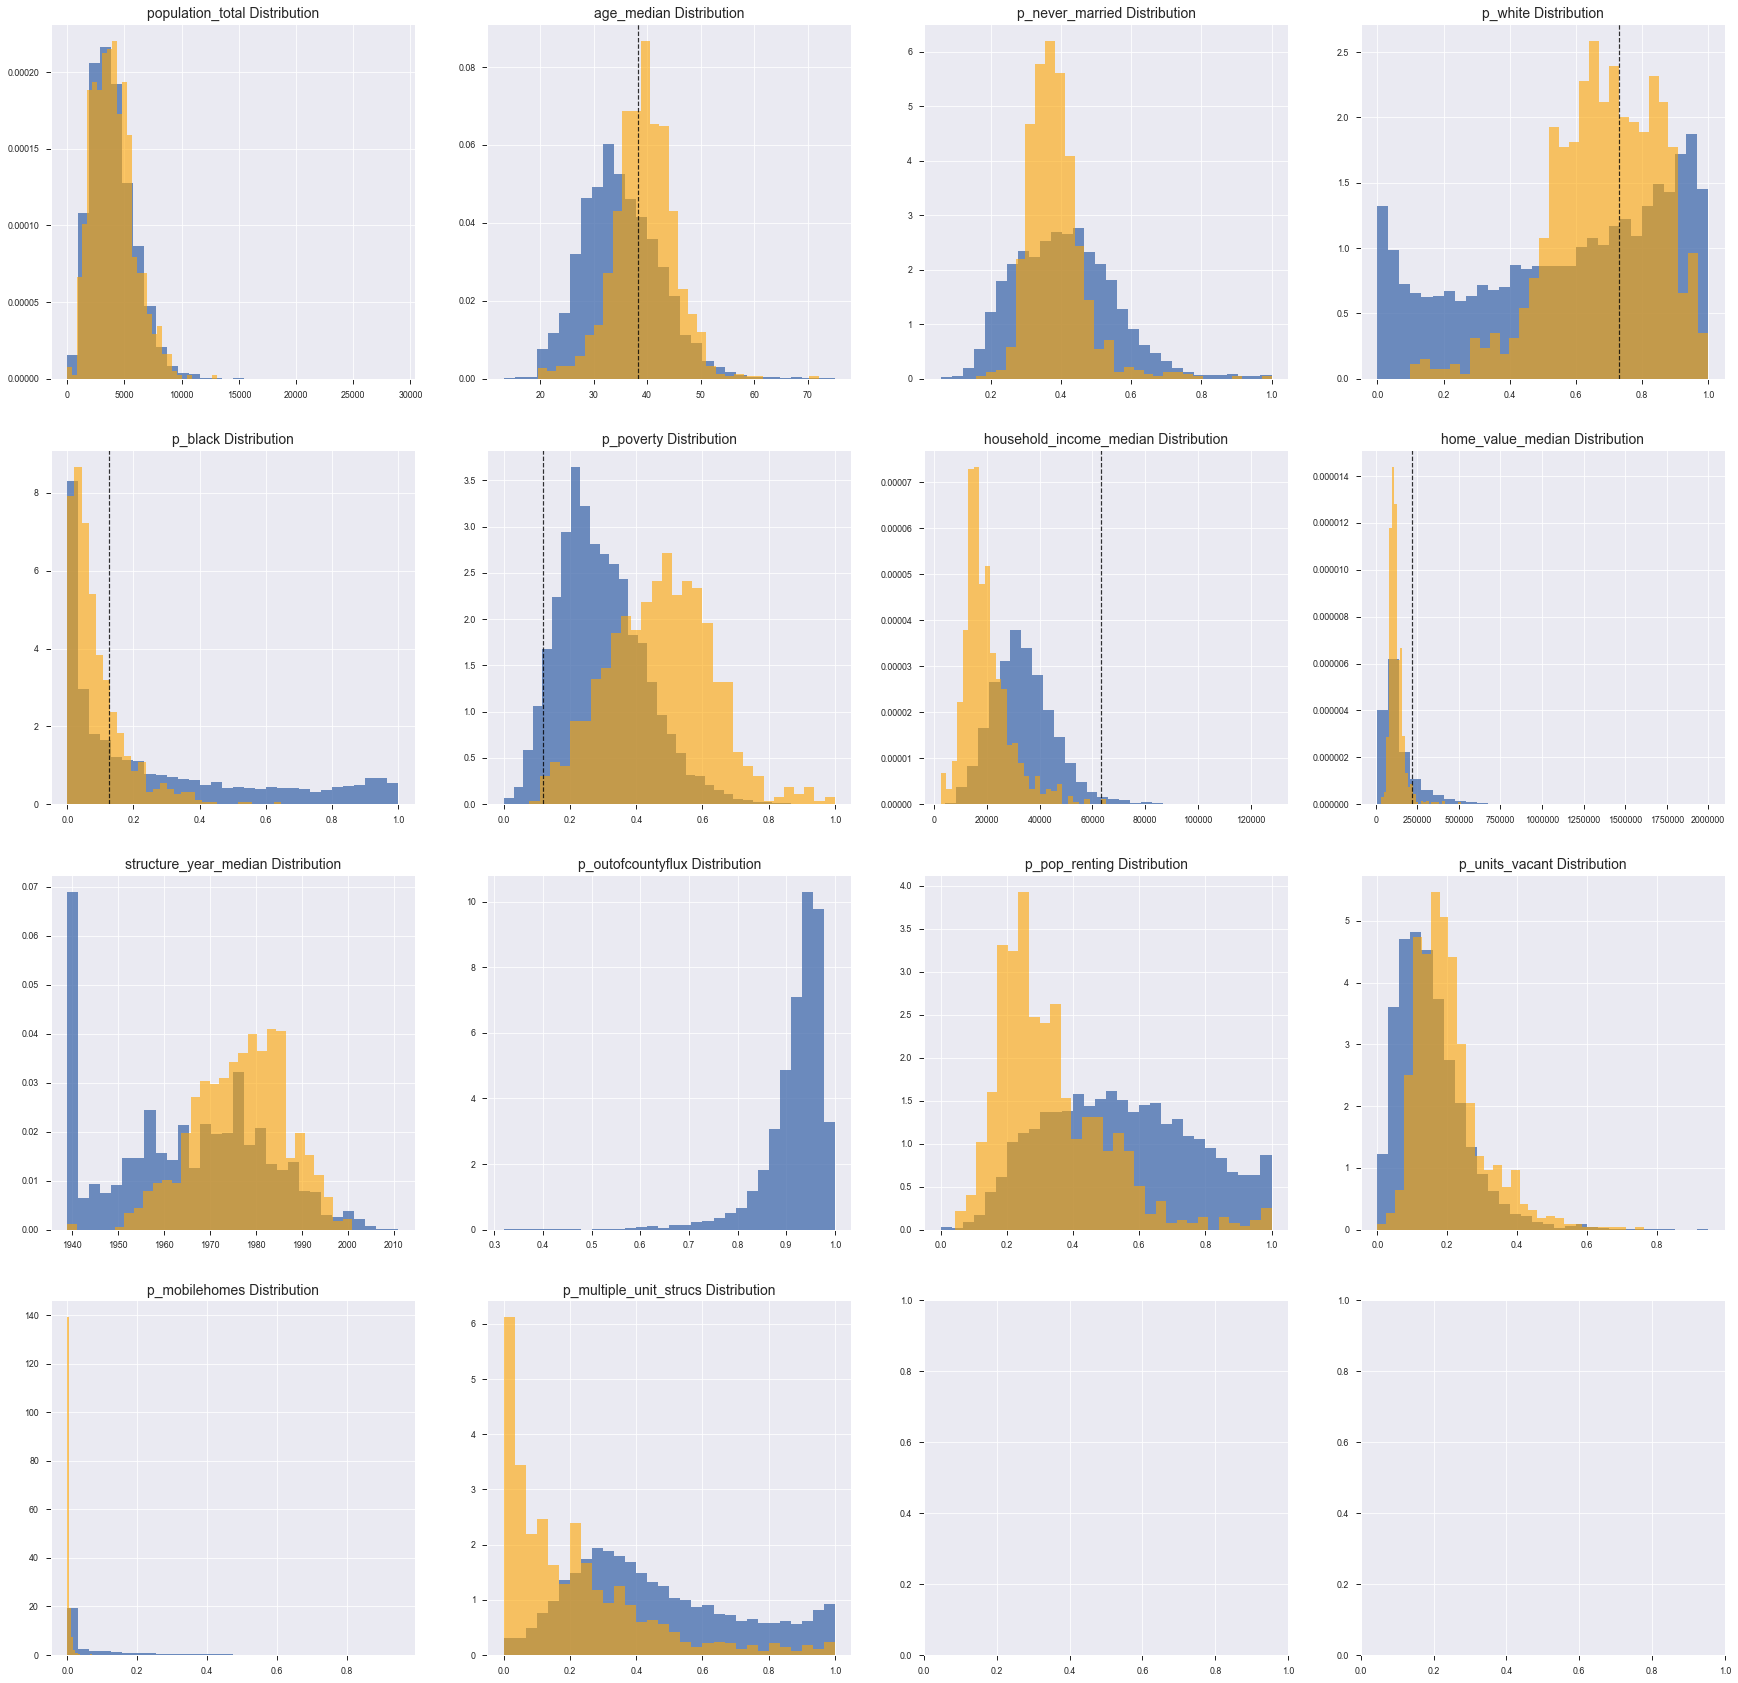

In [260]:
## Demographic plots
fig, axes = plt.subplots(4, 4, figsize=(30,30))

for ax, f in zip(axes.flatten(), plotter_features.columns):
    b = 30

    y_PR = PR[f].dropna().values
    y_others = all_others[f].dropna().values
    ax.hist(y_others, bins=b, density=True, alpha=0.8, label='All Other States')
    ax.hist(y_PR, bins=b, density=True, alpha=0.6, color='orange', label="Puerto Rico")
    ax.set_title(f"{f} Distribution", fontsize=14)
    if f in us_.keys():
        ax.axvline(us_[f], linestyle="--", color='k', alpha=0.8 )

plt.show()
    
    #plt.savefig(f"{demo_dir}/{f}_dist.png", dpi=120)
# features to go look back at : 
## structure year median - looks like PR has many more homes built 1940 (or before)
## multiple unit strucs – in general PR has more units per structure, 
## although maybe my definition of this feature isn't good